In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns


c:\Users\Azzahra\.conda\envs\ml\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv("bank-full.csv", delimiter=';')
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


## EDA

In [4]:
# Summary statistics for numerical columns
print("\nSummary Statistics:")
print(data.describe())


Summary Statistics:
                age        balance           day      duration      campaign  \
count  45211.000000   45211.000000  45211.000000  45211.000000  45211.000000   
mean      40.936210    1362.272058     15.806419    258.163080      2.763841   
std       10.618762    3044.765829      8.322476    257.527812      3.098021   
min       18.000000   -8019.000000      1.000000      0.000000      1.000000   
25%       33.000000      72.000000      8.000000    103.000000      1.000000   
50%       39.000000     448.000000     16.000000    180.000000      2.000000   
75%       48.000000    1428.000000     21.000000    319.000000      3.000000   
max       95.000000  102127.000000     31.000000   4918.000000     63.000000   

              pdays      previous  
count  45211.000000  45211.000000  
mean      40.197828      0.580323  
std      100.128746      2.303441  
min       -1.000000      0.000000  
25%       -1.000000      0.000000  
50%       -1.000000      0.000000  
75%   

In [5]:
# Checking for missing values
print("\nMissing Values:")
print(data.isnull().sum())


Missing Values:
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64


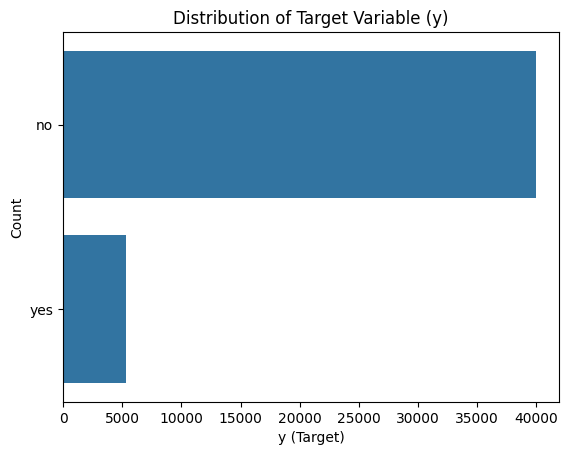

In [6]:
# Distribution of target variable 'y'
sns.countplot(data['y'])
plt.title('Distribution of Target Variable (y)')
plt.xlabel('y (Target)')
plt.ylabel('Count')
plt.show()

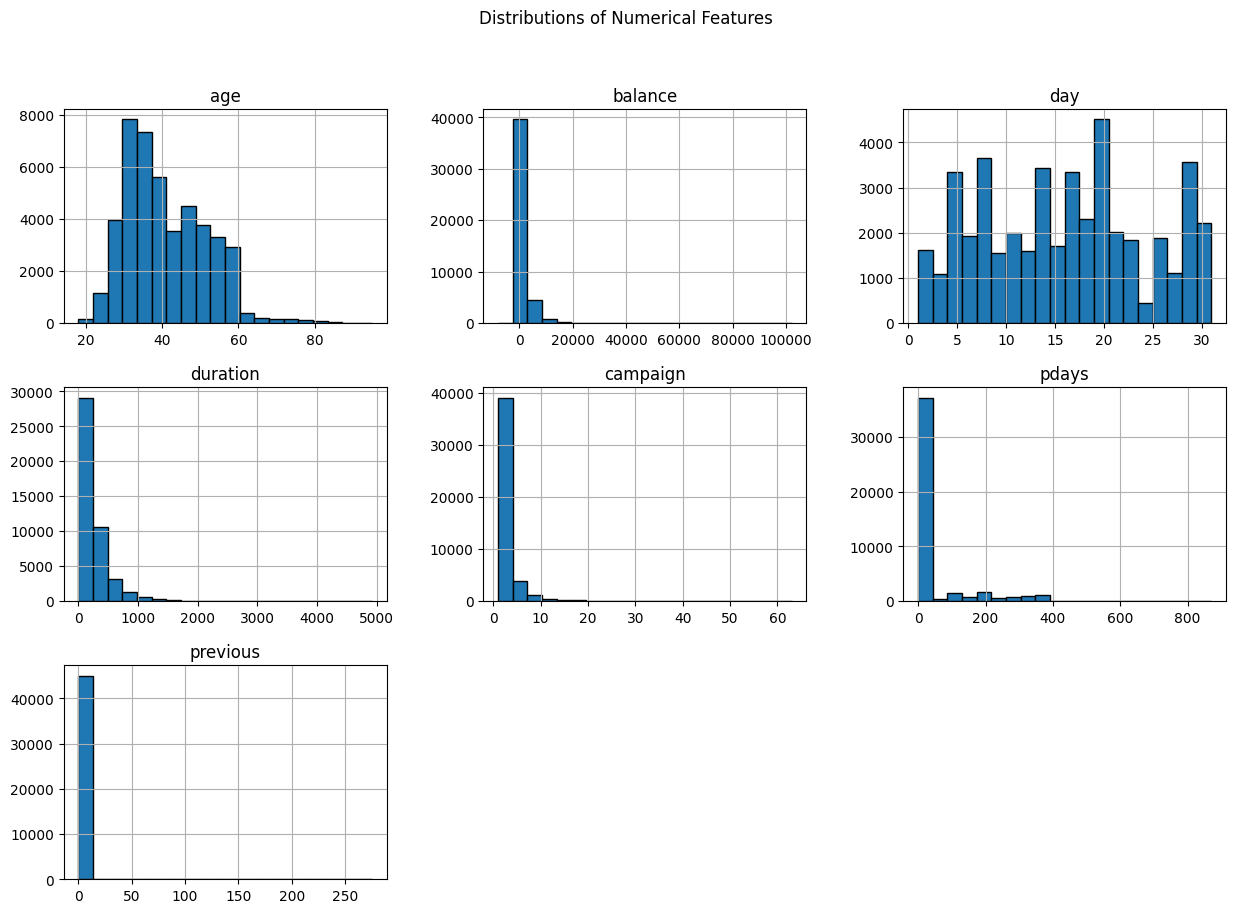

In [7]:
# Distribution of numerical variables
numerical_cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
data[numerical_cols].hist(figsize=(15, 10), bins=20, edgecolor='black')
plt.suptitle('Distributions of Numerical Features')
plt.show()

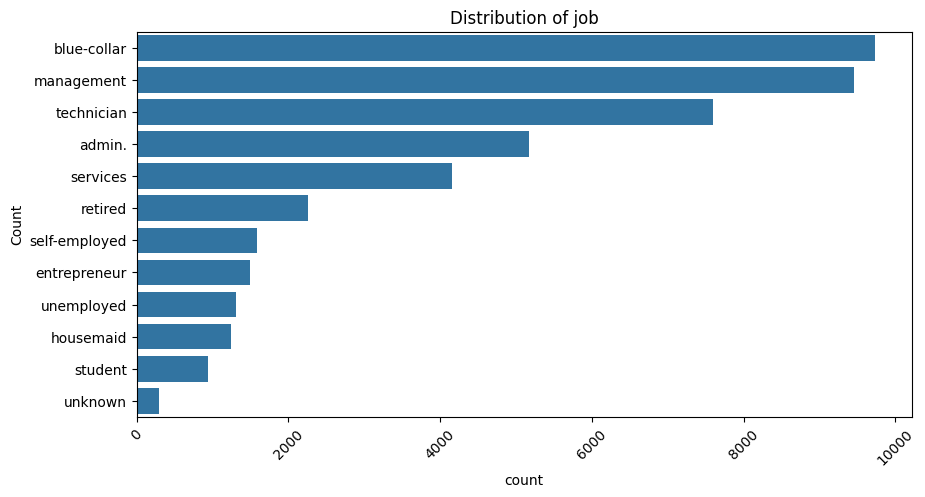

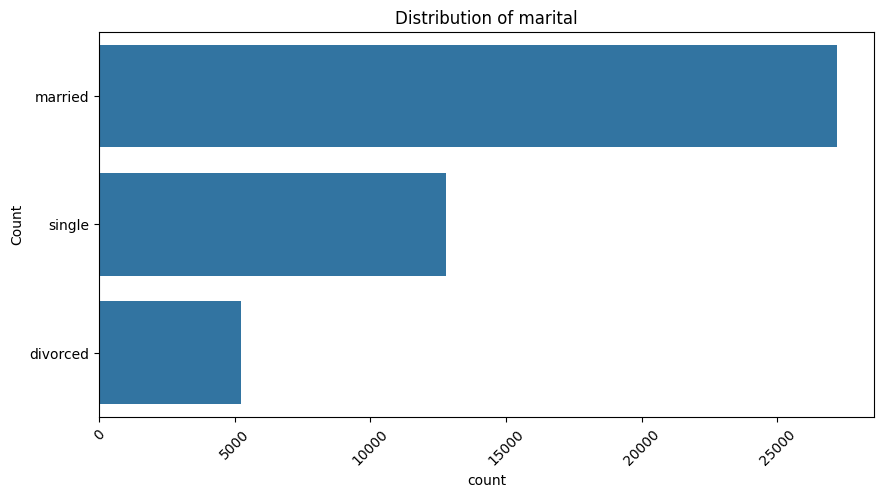

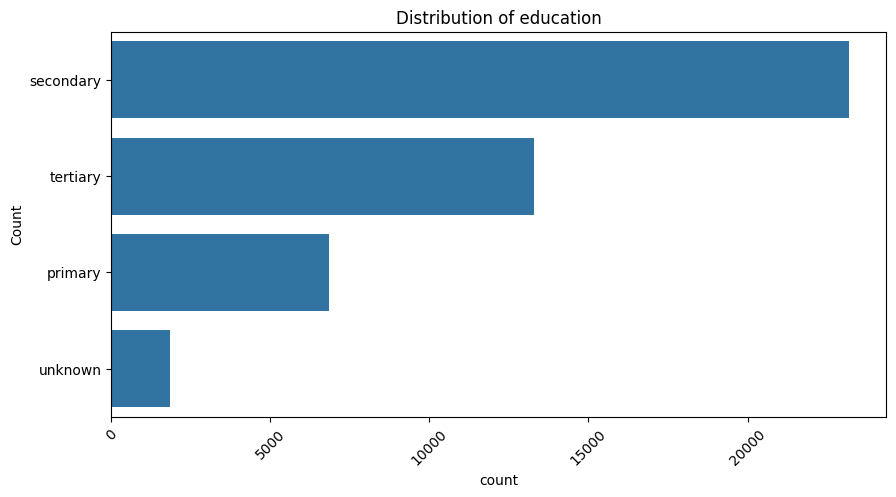

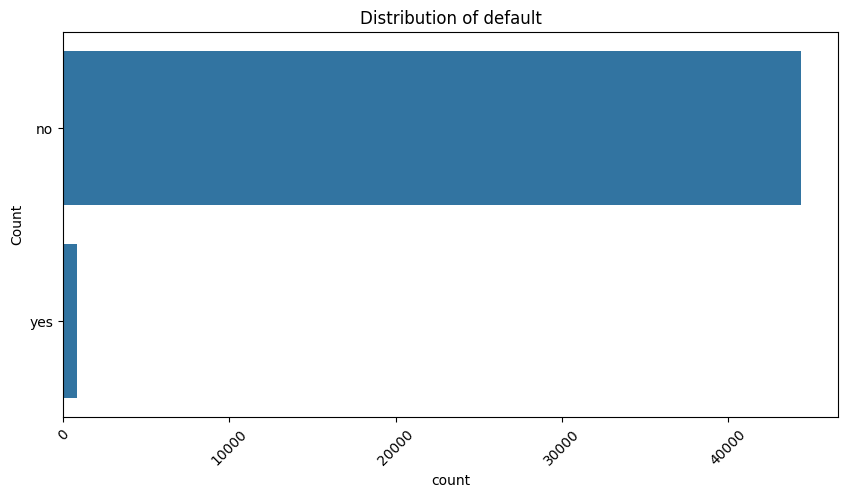

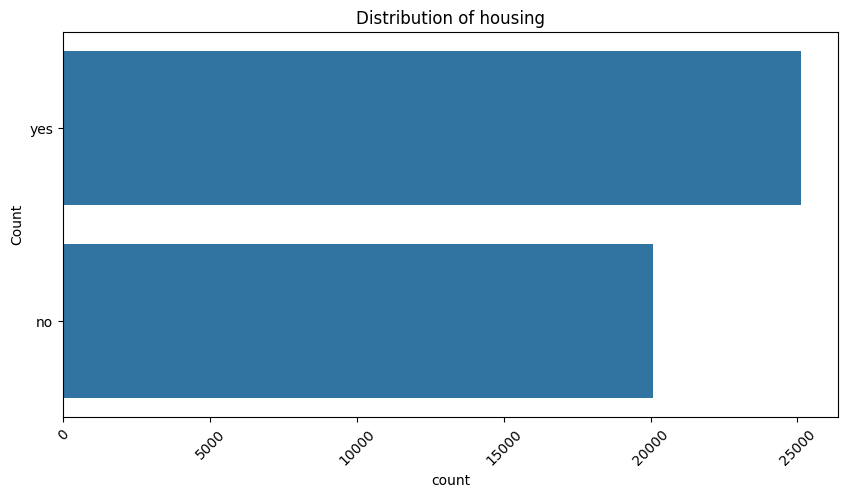

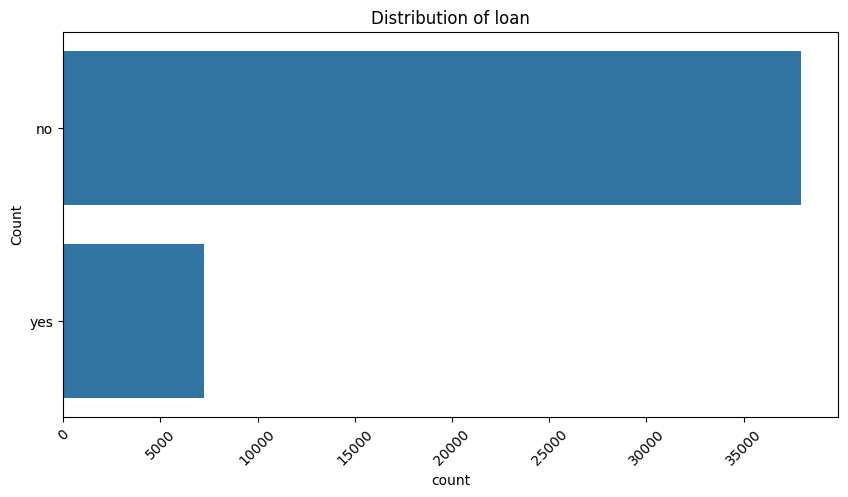

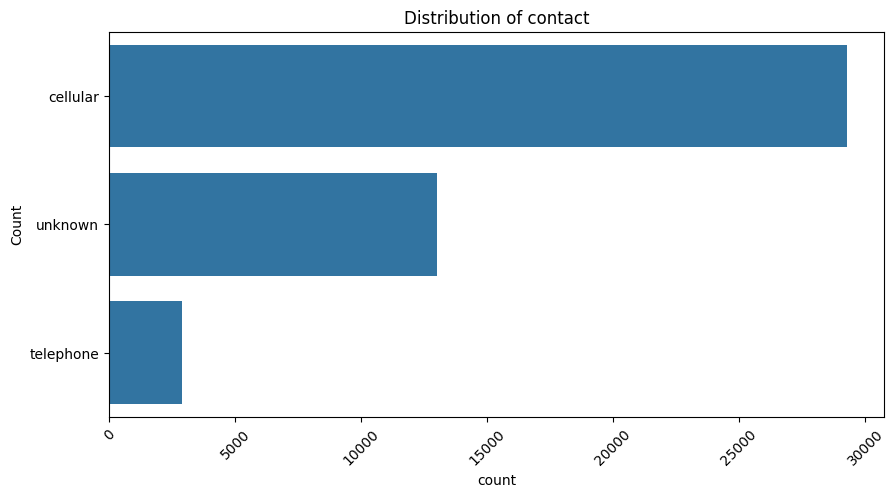

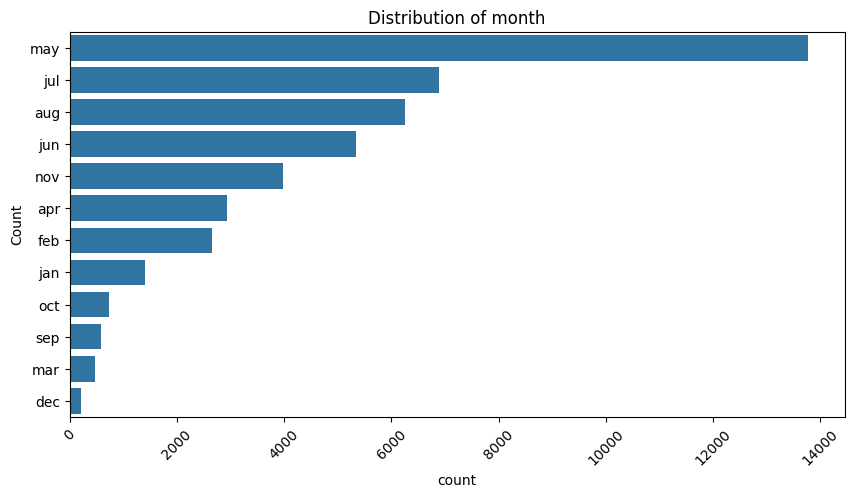

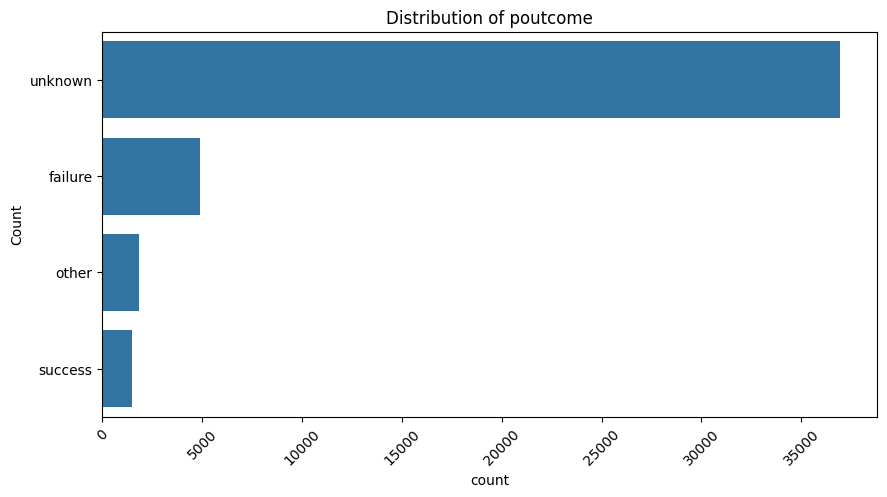

In [8]:
# Categorical variables analysis
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

for col in categorical_cols:
    plt.figure(figsize=(10, 5))
    sns.countplot(data[col], order=data[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.ylabel('Count')
    plt.show()

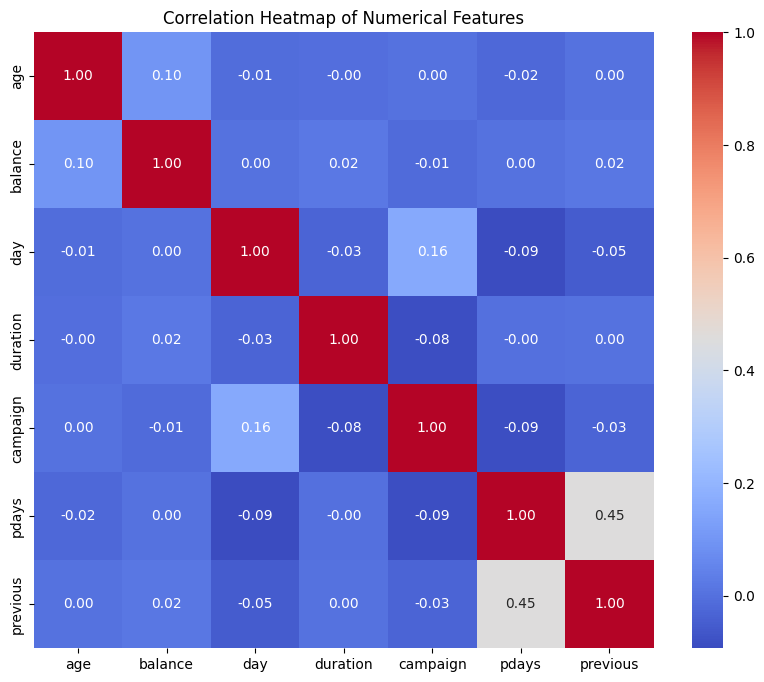

In [9]:
# Correlation heatmap for numerical features
correlation_matrix = data[numerical_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

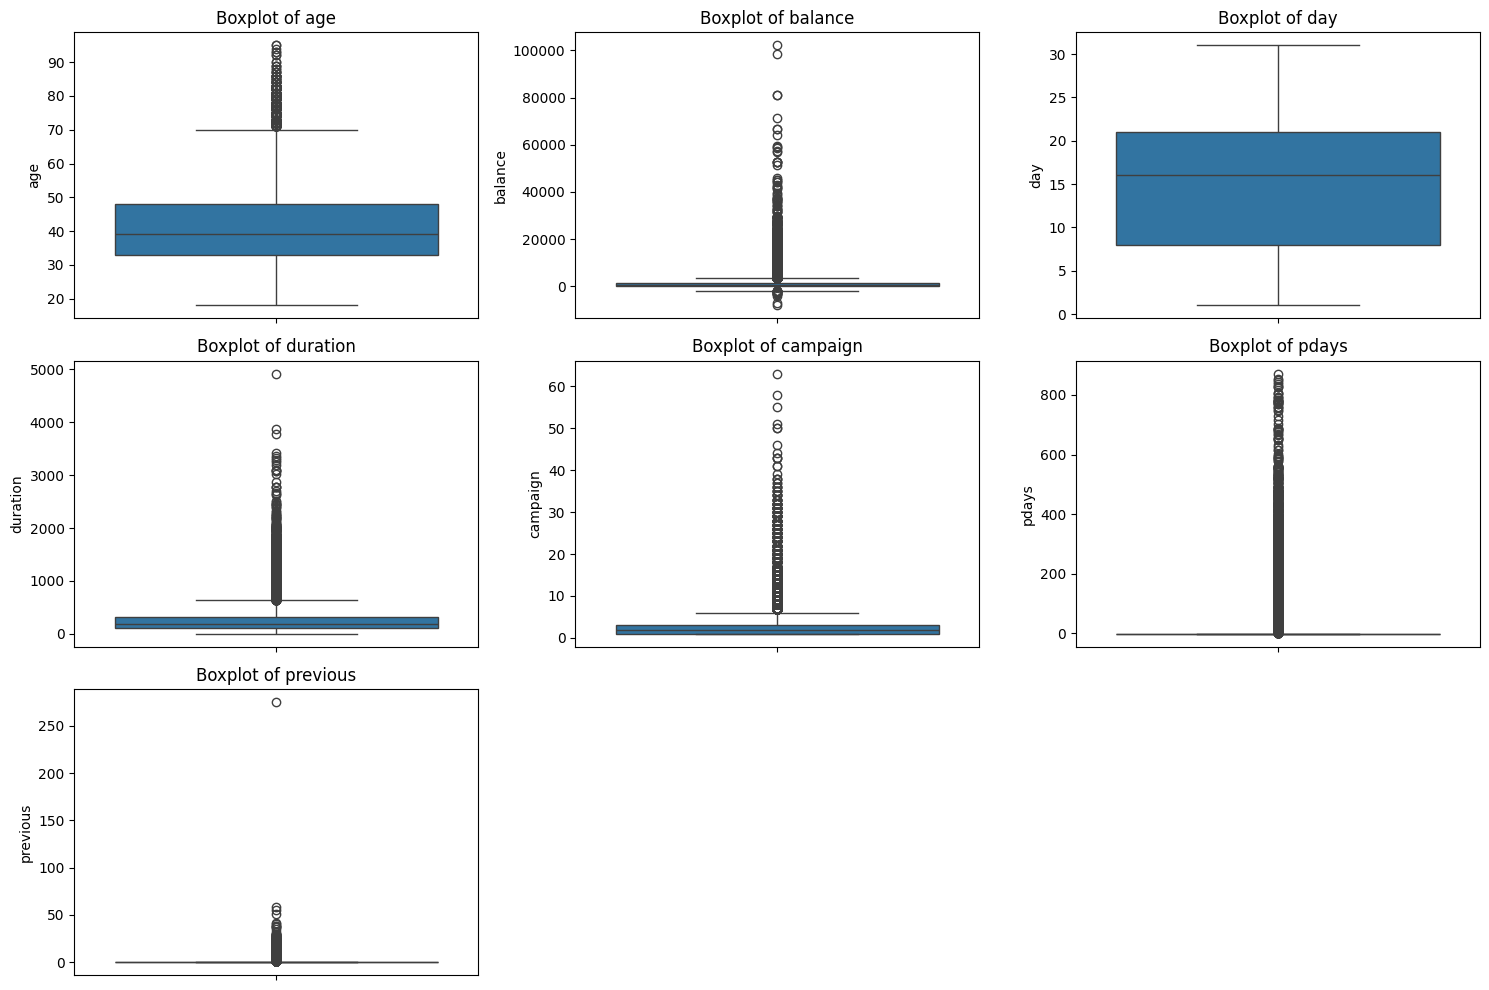

In [10]:
# Boxplot to check outliers in numerical features
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(data[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()


## RNN

In [11]:
import torch
if torch.cuda.is_available():
    print("GPU is available:", torch.cuda.get_device_name(0))
else:
    print("GPU is not available, using CPU.")

GPU is available: NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [12]:
# Preprocessing
def preprocess_data(data):
    X = data.drop('y', axis=1)
    X = pd.get_dummies(X)
    y = data['y'].apply(lambda x: 1 if x == 'yes' else 0)

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = preprocess_data(data)

# Dataset class
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [13]:
# Define RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, pooling='max'):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.pooling = pooling
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        if self.pooling == 'max':
            out = torch.max(out, dim=1).values
        elif self.pooling == 'avg':
            out = torch.mean(out, dim=1)
        out = self.fc(out)
        return out

In [14]:
# Training function
def train_model(model, optimizer, criterion, scheduler, num_epochs, early_stopper, train_loader, test_loader):
    best_loss = float('inf')
    patience_counter = 0
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch.unsqueeze(1))
            loss = criterion(outputs.squeeze(), y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        model.eval()
        test_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch.unsqueeze(1))
                loss = criterion(outputs.squeeze(), y_batch)
                test_loss += loss.item()
                predictions = torch.round(torch.sigmoid(outputs.squeeze()))
                correct += (predictions == y_batch).sum().item()
                total += y_batch.size(0)
        test_loss /= len(test_loader)
        accuracy = correct / total

        scheduler.step(test_loss)

        if test_loss < best_loss:
            best_loss = test_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter > early_stopper:
            print("Early stopping triggered")
            break

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}")

    return accuracy

In [15]:
# Experiment configurations
hidden_sizes = [16, 32, 64]
poolings = ['max', 'avg']
epochs_list = [5, 50, 100, 250, 350]
optimizers = ['SGD', 'RMSprop', 'Adam']
early_stopper = 10

# Run experiments for RNN and save results
results_rnn = []
for hidden_size in hidden_sizes:
    for pooling in poolings:
        for optimizer_name in optimizers:
            for num_epochs in epochs_list:
                print("=====================================================================")
                print(f"\nConfiguration: RNN Hidden Size={hidden_size}, Pooling={pooling}, Optimizer={optimizer_name}, Epochs={num_epochs}")
                model = RNNModel(input_size=X_train.shape[1], hidden_size=hidden_size, num_layers=1, output_size=1, pooling=pooling)
                criterion = nn.BCEWithLogitsLoss()

                if optimizer_name == 'SGD':
                    optimizer = optim.SGD(model.parameters(), lr=0.01)
                elif optimizer_name == 'RMSprop':
                    optimizer = optim.RMSprop(model.parameters(), lr=0.01)
                elif optimizer_name == 'Adam':
                    optimizer = optim.Adam(model.parameters(), lr=0.01)

                scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, verbose=True)
                accuracy = train_model(model, optimizer, criterion, scheduler, num_epochs, early_stopper, train_loader, test_loader)

                results_rnn.append({
                    'Model Type': 'RNN',
                    'Hidden Size': hidden_size,
                    'Pooling': pooling,
                    'Optimizer': optimizer_name,
                    'Epochs': num_epochs,
                    'Accuracy': accuracy
                })

results_rnn_df = pd.DataFrame(results_rnn)
results_rnn_df.to_csv('Experiment_results_rnn.csv', index=False)


Configuration: RNN Hidden Size=16, Pooling=max, Optimizer=SGD, Epochs=5
Epoch 1/5, Train Loss: 0.4404, Test Loss: 0.3387, Accuracy: 0.8854
Epoch 2/5, Train Loss: 0.2995, Test Loss: 0.2821, Accuracy: 0.8909
Epoch 3/5, Train Loss: 0.2625, Test Loss: 0.2573, Accuracy: 0.8944
Epoch 4/5, Train Loss: 0.2453, Test Loss: 0.2457, Accuracy: 0.8966
Epoch 5/5, Train Loss: 0.2362, Test Loss: 0.2399, Accuracy: 0.8986

Configuration: RNN Hidden Size=16, Pooling=max, Optimizer=SGD, Epochs=50
Epoch 1/50, Train Loss: 0.4194, Test Loss: 0.3207, Accuracy: 0.8848
Epoch 2/50, Train Loss: 0.2850, Test Loss: 0.2703, Accuracy: 0.8942
Epoch 3/50, Train Loss: 0.2532, Test Loss: 0.2518, Accuracy: 0.8993
Epoch 4/50, Train Loss: 0.2415, Test Loss: 0.2451, Accuracy: 0.8987
Epoch 5/50, Train Loss: 0.2364, Test Loss: 0.2423, Accuracy: 0.9011
Epoch 6/50, Train Loss: 0.2340, Test Loss: 0.2407, Accuracy: 0.9021
Epoch 7/50, Train Loss: 0.2325, Test Loss: 0.2395, Accuracy: 0.9018
Epoch 8/50, Train Loss: 0.2313, Test Loss:

## DEEP RNN

In [16]:
# Define Deep RNN model
class DeepRNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, pooling='max'):
        super(DeepRNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.pooling = pooling
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        if self.pooling == 'max':
            out = torch.max(out, dim=1).values
        elif self.pooling == 'avg':
            out = torch.mean(out, dim=1)
        out = self.fc(out)
        return out

In [17]:
# Experiment configurations
hidden_sizes = [16, 32, 64]
poolings = ['max', 'avg']
epochs_list = [5, 50, 100, 250, 350]
optimizers = ['SGD', 'RMSprop', 'Adam']
early_stopper = 10

# Run experiments for Deep RNN and save results
results_deep_rnn = []
for hidden_size in hidden_sizes:
    for pooling in poolings:
        for optimizer_name in optimizers:
            for num_epochs in epochs_list:
                print("=====================================================================")
                print(f"\nConfiguration: Deep RNN Hidden Size={hidden_size}, Pooling={pooling}, Optimizer={optimizer_name}, Epochs={num_epochs}")
                model = DeepRNNModel(input_size=X_train.shape[1], hidden_size=hidden_size, num_layers=3, output_size=1, pooling=pooling)
                criterion = nn.BCEWithLogitsLoss()

                if optimizer_name == 'SGD':
                    optimizer = optim.SGD(model.parameters(), lr=0.01)
                elif optimizer_name == 'RMSprop':
                    optimizer = optim.RMSprop(model.parameters(), lr=0.01)
                elif optimizer_name == 'Adam':
                    optimizer = optim.Adam(model.parameters(), lr=0.01)

                scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, verbose=True)
                accuracy = train_model(model, optimizer, criterion, scheduler, num_epochs, early_stopper, train_loader, test_loader)

                results_deep_rnn.append({
                    'Model Type': 'Deep RNN',
                    'Hidden Size': hidden_size,
                    'Pooling': pooling,
                    'Optimizer': optimizer_name,
                    'Epochs': num_epochs,
                    'Accuracy': accuracy
                })

results_deep_rnn_df = pd.DataFrame(results_deep_rnn)
results_deep_rnn_df.to_csv('Experiment_results_deep_rnn.csv', index=False)


Configuration: Deep RNN Hidden Size=16, Pooling=max, Optimizer=SGD, Epochs=5
Epoch 1/5, Train Loss: 0.3949, Test Loss: 0.3591, Accuracy: 0.8794
Epoch 2/5, Train Loss: 0.3388, Test Loss: 0.3374, Accuracy: 0.8794
Epoch 3/5, Train Loss: 0.3067, Test Loss: 0.2964, Accuracy: 0.8818
Epoch 4/5, Train Loss: 0.2666, Test Loss: 0.2627, Accuracy: 0.8943
Epoch 5/5, Train Loss: 0.2437, Test Loss: 0.2471, Accuracy: 0.8974

Configuration: Deep RNN Hidden Size=16, Pooling=max, Optimizer=SGD, Epochs=50
Epoch 1/50, Train Loss: 0.4028, Test Loss: 0.3413, Accuracy: 0.8794
Epoch 2/50, Train Loss: 0.3096, Test Loss: 0.2944, Accuracy: 0.8823
Epoch 3/50, Train Loss: 0.2644, Test Loss: 0.2584, Accuracy: 0.8933
Epoch 4/50, Train Loss: 0.2418, Test Loss: 0.2456, Accuracy: 0.8990
Epoch 5/50, Train Loss: 0.2336, Test Loss: 0.2402, Accuracy: 0.9015
Epoch 6/50, Train Loss: 0.2299, Test Loss: 0.2375, Accuracy: 0.9014
Epoch 7/50, Train Loss: 0.2274, Test Loss: 0.2358, Accuracy: 0.9021
Epoch 8/50, Train Loss: 0.2260, 

## KESIMPULAN

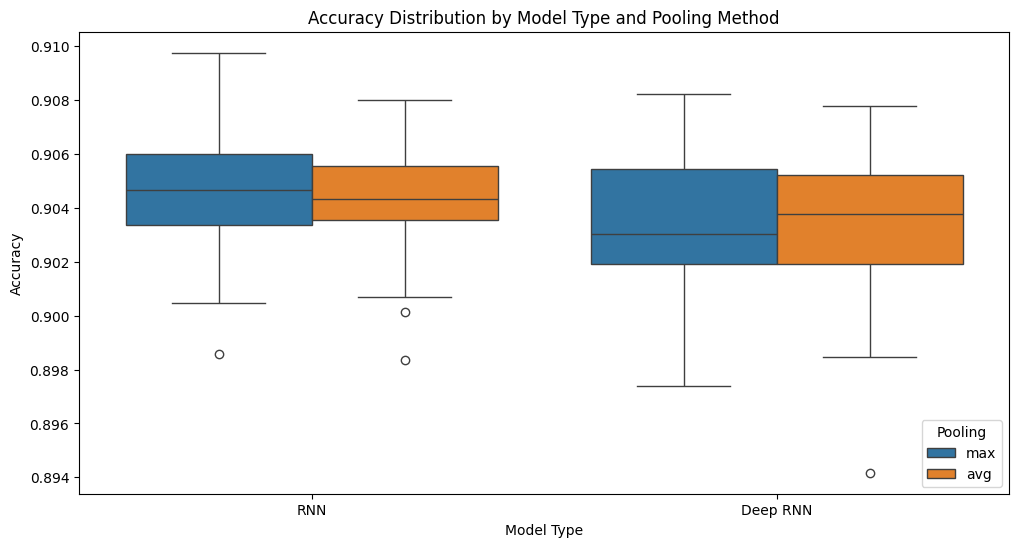

In [19]:
# Combine results and visualize
def visualize_results():
    combined_results = pd.concat([results_rnn_df, results_deep_rnn_df])

    # Plot Accuracy Distribution by Model Type
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=combined_results, x='Model Type', y='Accuracy', hue='Pooling')
    plt.title('Accuracy Distribution by Model Type and Pooling Method')
    plt.ylabel('Accuracy')
    plt.xlabel('Model Type')
    plt.legend(title='Pooling', loc='lower right')
    plt.savefig('accuracy_distribution.png')
    plt.show()
visualize_results()


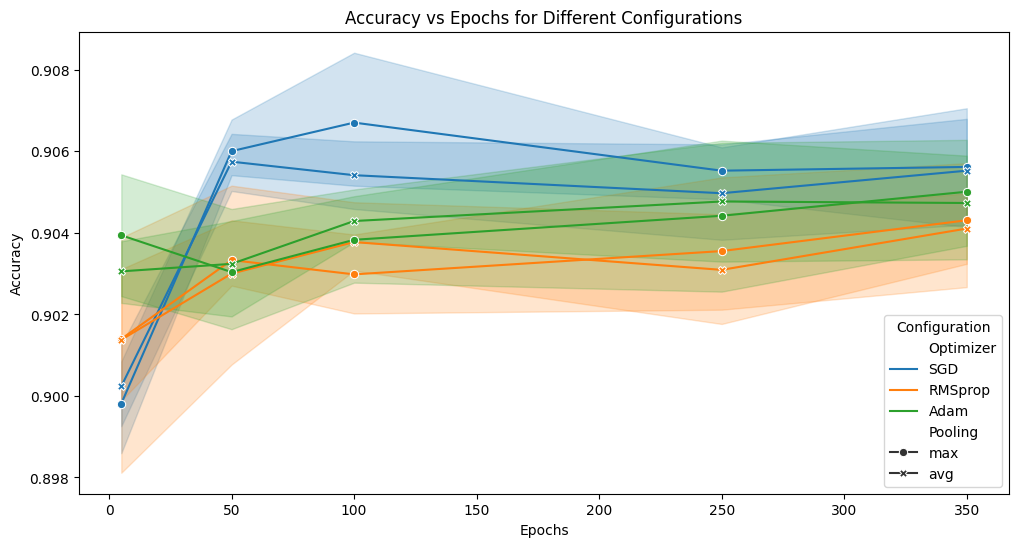

In [24]:
def visualize_results():
    combined_results = pd.concat([results_rnn_df, results_deep_rnn_df])

    # Plot Accuracy vs Epochs
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=combined_results, x='Epochs', y='Accuracy', hue='Optimizer', style='Pooling', markers=True, dashes=False)
    plt.title('Accuracy vs Epochs for Different Configurations')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(title='Configuration', loc='lower right')
    plt.savefig('accuracy_vs_epochs.png')
    plt.show()
visualize_results()


In [21]:
# Top 10 configurations by accuracy
combined_results = pd.concat([results_rnn_df, results_deep_rnn_df])
top_10 = combined_results.sort_values(by='Accuracy', ascending=False).head(10)
print("Top 10 Configurations by Accuracy:")

# Save as table
from tabulate import tabulate
print(tabulate(top_10, headers='keys', tablefmt='pretty', showindex=False))


Top 10 Configurations by Accuracy:
+------------+-------------+---------+-----------+--------+--------------------+
| Model Type | Hidden Size | Pooling | Optimizer | Epochs |      Accuracy      |
+------------+-------------+---------+-----------+--------+--------------------+
|    RNN     |     64      |   max   |    SGD    |  100   | 0.9097644586973349 |
|    RNN     |     32      |   max   |    SGD    |  100   | 0.9087692137564968 |
|  Deep RNN  |     64      |   max   |    SGD    |  350   | 0.9082162999004755 |
|    RNN     |     16      |   avg   |  RMSprop  |   50   | 0.907995134358067  |
|    RNN     |     64      |   avg   |   Adam    |  250   | 0.9077739688156585 |
|    RNN     |     64      |   max   |    SGD    |  350   | 0.9077739688156585 |
|  Deep RNN  |     64      |   avg   |    SGD    |  350   | 0.9077739688156585 |
|  Deep RNN  |     32      |   max   |    SGD    |   50   | 0.9077739688156585 |
|    RNN     |     16      |   max   |   Adam    |  350   | 0.907663386044